In [7]:
import numpy 

In [8]:
import json
import requests 
# Suppressing warnings (optional)
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)  # Disable warnings about insecure requests

In [9]:
# default Quokka address (change if you have your own!):
#my_quokka = 'theq-adc1cf'
my_quokka = 'quokka1'

In [10]:
# create_ciruit (turn on your quantum computer for a qubit array between qubits = 1 and qubits = 30)
# Initial_state is a integer to initalise all qubit,
# most often initial_state = 0.

def create_circuit(qubits,initial_state):
    data = {
        'operation': 'create_circuit',
        'num_qubits': qubits
    }
    result = requests.post(req_str, json=data)
    json_obj = json.loads(result.content)
    reg_id = json_obj['result']

    data = {
        'operation': 'set_state',
        'register': reg_id,
        'state': initial_state,
        'complex_value': {'re': 1, 'im': 0}
    }
    result = requests.post(req_str, json=data, verify=False)
    return reg_id

# Gates.  gate_name and params are specified from the list above
# Gates only return 'True' and 'False' to indicate if they were successsfully applied
def gate(register_id, gate_name, params):
    data = {
        'operation': 'gate',
        'register': register_id,
        'gate': gate_name
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data, verify=False)
    json_obj=json.loads(result.content)



    data.update(params)

    r = requests.post(req_str, json=data, verify=False)

    try:
        j = r.json()
    except ValueError:
        raise RuntimeError(f"Non-JSON response (HTTP {r.status_code}):\n{r.text[:300]}")

    if 'result' not in j:
        # This will show the Quokka-specific error + error_code
        raise RuntimeError(f"Quokka returned an error:\n{j}")





    return json_obj['result']

# params contain an array of qubit numbers to measure, 'lq2m': [0,1,3] would measure qubits 0, 1 and 3 and return the
# corresponding 3-bit integer value from 0 to 7.
# concepually easiest is to measure qubits one-by-one, hence to measure qubit 4, 'lq2m': [4]
def measure_qubit(register_id, params):
    data = {
        'operation': 'measure',
        'register': register_id,
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data, verify=False)

    json_obj = json.loads(result.content)
    return json_obj['result']

# Always call destroy_circuit to terminate simulation (turn off your QC)
def destroy_circuit(register_id):
  data = {
        'operation': 'destroy_circuit',
        'register': register_id
  }
  result = requests.post(req_str, json=data, verify=False)

In [ ]:
# define the web address for batch operations
batch_url = f"http://{my_quokka}.quokkacomputing.com/qsim/perform_experiment"

# circuit_size defines the number of qubits
circuit_size = 2

# init sets the initial binary state of the computer (expressed as init = Integer)
init = 0


Measure op being sent: {'operation': 'measure', 'lq2m': [0, 1]}
Raw measurement results (integers):
[0, 0, 2, 0, 2, 0, 2, 0, 2, 2]
Measurement results (bitstrings):
Shot 1: 00
Shot 2: 00
Shot 3: 10
Shot 4: 00
Shot 5: 10
Shot 6: 00
Shot 7: 10
Shot 8: 00
Shot 9: 10
Shot 10: 10


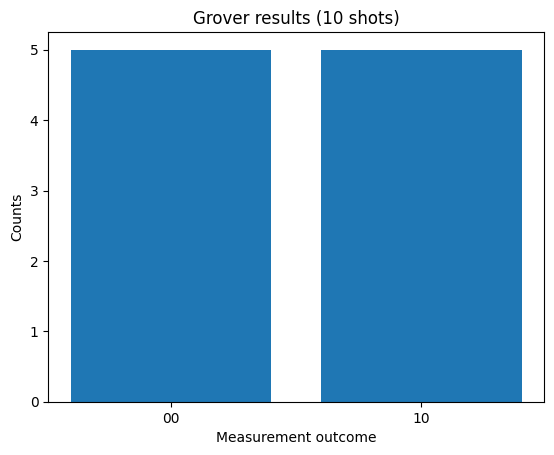

In [12]:
import matplotlib.pyplot as plt
import numpy as np

shots = 10
results = []

ops = [
    {"operation": "create_circuit", "num_qubits": 2},
    {"operation": "set_state", "state": 0, "complex_value": {"re": 1, "im": 0}},

    {"operation": "gate", "gate": "hadamard", "q": 0},
    {"operation": "gate", "gate": "cphase", "q_control": 0, "q_target": 1, "theta": np.pi},

    {"operation": "measure", "lq2m": [0, 1], "count": shots},
    {"operation": "destroy_circuit"}
]

measure_idx = next(i for i, op in enumerate(ops) if op["operation"] == "measure")

# Safety: remove unsupported 'count' if it exists anywhere
for op in ops:
    if op.get("operation") == "measure" and "count" in op:
        op.pop("count")

# Print exactly what we will send for measurement
print("Measure op being sent:", next(op for op in ops if op.get("operation") == "measure"))

for _ in range(shots):
    resp = requests.post(batch_url, json=ops, verify=False)
    out = resp.json()

    if isinstance(out, dict) and "error" in out:
        raise RuntimeError(out)

    meas_item = out[measure_idx]
    meas_val = meas_item["result"] if isinstance(meas_item, dict) else meas_item
    results.append(meas_val)

if isinstance(out, dict) and "error" in out:
    print("Server error:", out)
    print("Measure op sent:", next(op for op in ops if op.get("operation") == "measure"))
    raise RuntimeError(out)

# ---- PRINT RESULTS ----
print("Raw measurement results (integers):")
print(results)

bitstrings = [format(int(r), "02b") for r in results]

print("Measurement results (bitstrings):")
for i, b in enumerate(bitstrings, start=1):
    print(f"Shot {i}: {b}")

bitstrings = [format(int(r), "02b") for r in results]

x = sorted(set(bitstrings))
y = [bitstrings.count(v) for v in x]

plt.bar(x, y)
plt.xticks(x)
plt.xlabel("Measurement outcome")
plt.ylabel("Counts")
plt.title(f"Grover results ({shots} shots)")
plt.show()
